# Reading Comprehension /Question Answering

Code for the Attention reader describe in the paper: https://arxiv.org/pdf/1606.02858v2.pdf

In [1]:
import torch

import pandas as pd
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import random
import torch.optim as optim

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import math
import pickle

from torchtext.data import Field
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from collections import Counter

from tqdm.notebook import tqdm

In [2]:
# change your path here
PATH = Path("/data2/yinterian/reading_comprehension")

## Get data

Get the data from here https://cs.nyu.edu/~kcho/DMQA/

In [3]:
ls $PATH/data/cnn/questions

test/  training/  validation/


In [4]:
train_path = PATH/"data/cnn/questions/training"
valid_path = PATH/"data/cnn/questions/validation"
train_questions = list(Path(train_path).glob('*.question'))
valid_questions = list(Path(valid_path).glob('*.question'))

In [5]:
len(train_questions), len(valid_questions)

(380298, 3924)

In [6]:
train_questions[:5]

[PosixPath('/data2/yinterian/reading_comprehension/data/cnn/questions/training/8914bf26caeb006f46972fc09b6d54157f11c9a9.question'),
 PosixPath('/data2/yinterian/reading_comprehension/data/cnn/questions/training/8c95933a89ed1868c0a0c6b8eff519d71b9278f2.question'),
 PosixPath('/data2/yinterian/reading_comprehension/data/cnn/questions/training/2f97a8b7e4a2566bfafce1657a7ae3430ea873bf.question'),
 PosixPath('/data2/yinterian/reading_comprehension/data/cnn/questions/training/bc06dc9ba6b2e06961f0d147f80533e044aa8dbb.question'),
 PosixPath('/data2/yinterian/reading_comprehension/data/cnn/questions/training/700864902e8c607caf14bb436946cc74ecb5cef8.question')]

Note that this data has already been cleaned.

In [7]:
! cat $PATH/data/cnn/questions/training/55482c04581f3c7ca514c55f71c45230bdf4c824.question

http://web.archive.org/web/20150421065616id_/http://www.cnn.com/2015/01/02/politics/clinton-aide-white-house/

@entity0 ( @entity1 ) the @entity4 administration 's top aide in charge of promoting @entity7 enrollment is leaving the @entity8 , possibly with eyes on helping another @entity10 win the job in 2016 . @entity12 , an aide to @entity14 's 2008 presidential campaign , is leaving the @entity8 to rejoin 270 strategies , a @entity17 consulting firm he helped found . " i am thrilled today to announce i will be returning to the management team of 270 strategies , " @entity12 , who served as deputy director of the @entity19 , said in a statement . " i want to thank the president for the opportunity to serve and senior advisor @entity25 for being an amazing boss and mentor . " word of @entity12 's departure from the @entity8 had been rumored for months , both inside and outside 270 strategies . @entity30 reported in december that he was thought to rejoin the consulting firm and the @ent

## Process the data

In [8]:
def process_question(in_file):    
    documents = []
    questions = []
    answers = []
    num_examples = 0
    f = open(in_file, 'r')
    lines = f.readlines()
    document = lines[2].strip()
    question = lines[4].strip()
    answer = lines[6].strip()
    assert("@placeholder" in question)
    assert("@entity" in answer)
    f.close()
    return document, question, answer

In [9]:
def relabeling(document, question, answer):
    
    q_words = question.split(' ')
    d_words = document.split(' ')
    assert answer in d_words
    

    entity_dict = {}
    entity_id = 0
    for word in d_words + q_words:
        if (word.startswith('@entity')) and (word not in entity_dict):
            entity_dict[word] = '@entity' + str(entity_id)
            entity_id += 1

    q_words = [entity_dict[w] if w in entity_dict else w for w in q_words]
    d_words = [entity_dict[w] if w in entity_dict else w for w in d_words]
    answer = entity_dict[answer]
    question = ' '.join(q_words)
    document = ' '.join(d_words)

    return document, question, answer  

In [10]:
document, question, answer = process_question(train_questions[2])
print(question, "==>", answer)
document, question, answer = relabeling(document, question, answer)
print(question, "==>", answer)

new imacs sport the latest @entity10 i5 / i7 @placeholder architecture ==> @entity12
new imacs sport the latest @entity2 i5 / i7 @placeholder architecture ==> @entity3


In [11]:
def load_data(paths):
    documents = []
    questions = []
    answers = []
    for path in tqdm(paths):
        document, question, answer = process_question(path)
        document, question, answer = relabeling(document, question, answer)
        documents.append(document)
        questions.append(question)
        answers.append(answer)
    return documents, questions, answers

In [12]:
# training
#documents, questions, answers = load_data(train_questions)

In [13]:
def build_dict(sentences, max_words=50000):
    """
        Build a dictionary for the words in `sentences`.
        Only the max_words ones are kept and the remaining will be mapped to <UNK>.
    """
    word_count = Counter()
    for sent in sentences:
        for w in sent.split(' '):
            word_count[w] += 1

    words = word_count.most_common(max_words)
    # leave 0 to UNK
    # leave 1 to delimiter |||
    return {w[0]: index + 2 for (index, w) in enumerate(words)}

In [15]:
#word_dict = build_dict(documents + questions)
#pickle.dump(word_dict, open(PATH/"word_dict.pickle", 'wb'))

In [30]:
entity_markers = list(set([w for w in word_dict.keys() if w.startswith('@entity')] + answers))
entity_markers = ['<unk_entity>'] + entity_markers
entity_dict = {w: index for (index, w) in enumerate(entity_markers)}

In [51]:
#entity_dict

In [33]:
num_labels = len(entity_dict)
num_labels

328

In [35]:
def vectorize(documents, questions, answers, word_dict, entity_dict):
    """
        Vectorize `examples`.
        in_x1, in_x2: sequences for document and question respecitvely.
        in_y: label
        in_l: whether the entity label occurs in the document.
    """
    in_x1 = []
    in_x2 = []
    in_l = np.zeros((len(documents), len(entity_dict)))
    in_y = []
    for idx, (d, q, a) in enumerate(zip(documents, questions, answers)):
        d_words = d.split(' ')
        q_words = q.split(' ')
        assert (a in d_words)
        seq1 = [word_dict[w] if w in word_dict else 0 for w in d_words]
        seq2 = [word_dict[w] if w in word_dict else 0 for w in q_words]
        if (len(seq1) > 0) and (len(seq2) > 0):
            in_x1.append(seq1)
            in_x2.append(seq2)
            in_l[idx, [entity_dict[w] for w in d_words if w in entity_dict]] = 1.0
            in_y.append(entity_dict[a] if a in entity_dict else 0)

    return in_x1, in_x2, in_l, in_y

In [36]:
train_x1, train_x2, train_l, train_y = vectorize(documents, questions, answers, word_dict, entity_dict)

In [48]:
train_x2[1]

[327, 2021, 5, 5863, 96, 62, 2, 4119, 7529, 11, 4801]

In [50]:
train_y[1]

187

In [53]:
documents, questions, answers = load_data(valid_questions)
valid_x1, valid_x2, valid_l, valid_y = vectorize(documents, questions, answers, word_dict, entity_dict)

In [60]:
valid_x2[10]

[96, 480, 504, 306, 10, 7200]

In [57]:
train_dict = {"x1": train_x1, "x2": train_x2, "l": train_l, "y": train_y}
valid_dict = {"x1": valid_x1, "x2": valid_x2, "l": valid_l, "y": valid_y}
pickle.dump(train_dict, open(PATH/"train_dict.pickle", 'wb'))
pickle.dump(valid_dict, open(PATH/"valid_dict.pickle", 'wb'))

## Dataset

In [16]:
train_dict = pickle.load(open(PATH/"train_dict.pickle", "rb"))
valid_dict  = pickle.load(open(PATH/"valid_dict.pickle", "rb"))

In [17]:
word_dict = pickle.load(open(PATH/"word_dict.pickle", 'rb'))
len(word_dict)

50000

In [18]:
len(train_dict["y"]), len(valid_dict["y"])

(380298, 3924)

In [19]:
class QADataset(Dataset):
    def __init__(self, d_dict):
        self.d_dict = d_dict 

    def __len__(self):
        return len(self.d_dict["y"])

    def __getitem__(self, idx):
        return self.d_dict["x1"][idx], self.d_dict["x2"][idx], self.d_dict["l"][idx], self.d_dict["y"][idx]

In [20]:
train_ds = QADataset(train_dict)
valid_ds = QADataset(valid_dict)

Recall:
* `x1` tokens from document
* `x2` tokens from question
* `l` entities present in the document
* `y` answer

In [21]:
x1, x2, l, y = train_ds[20]

In [27]:
len(x1), l.sum()

(1069, 19.0)

In [13]:
x2, y

([59, 14, 1063, 685, 42, 96, 327, 5, 1439, 2039, 13, 2, 346], 153)

In [28]:
# dynamic padding
def collate_fn(batch):
    x1 = [torch.LongTensor(sample[0]) for sample in batch] 
    x2 = [torch.LongTensor(sample[1]) for sample in batch] 
    L = torch.LongTensor([sample[2] for sample in batch])
    y = torch.LongTensor([sample[3] for sample in batch])
    x1lens = np.array([len(seq) for seq in x1])
    x2lens = np.array([len(seq) for seq in x2])
    
    # pad the batch
    padded_x1 = torch.zeros(len(x1), x1lens.max()).long()
    for idx, length in enumerate(x1lens):
        padded_x1[idx, x1lens.max() - length:] = x1[idx]
    
    padded_x2 = torch.zeros(len(x2), x2lens.max()).long()
    for idx, length in enumerate(x2lens):
        padded_x2[idx, x2lens.max() - length:] = x2[idx]
    
    return (padded_x1, padded_x2, L, y)

In [29]:
batch = [train_ds[0], train_ds[1], train_ds[10]]

In [30]:
x1, x2, l, y = collate_fn(batch)

In [31]:
x1.shape, x2.shape, l.shape, y

(torch.Size([3, 1184]),
 torch.Size([3, 13]),
 torch.Size([3, 328]),
 tensor([ 94, 187, 187]))

## Debugging Model

In [16]:
train_dl = DataLoader(train_ds, batch_size=3, shuffle=False, collate_fn=collate_fn)
x1, x2, l, y = next(iter(train_dl))

In [17]:
vocab_size = 50000

In [18]:
emb = nn.Embedding(vocab_size, 10, padding_idx=0)
gru1 = nn.GRU(10, 7, batch_first=True)
gru2 = nn.GRU(10, 5, batch_first=True)

In [19]:
x1 = emb(x1)
x2 = emb(x2)
print(x1.shape, x2.shape)

torch.Size([3, 1184, 10]) torch.Size([3, 12, 10])


In [20]:
hts1, ht1 = gru1(x1)
hts2, ht2 = gru2(x2)
hts1.shape, ht2[0].shape

(torch.Size([3, 1184, 7]), torch.Size([3, 5]))

In [21]:
# Note this is just a matrix multiplication
liner_att = nn.Linear(7, 5, bias=False)

In [22]:
Wp = liner_att(hts1)
Wp.shape

torch.Size([3, 1184, 5])

In [23]:
q = ht2[0].unsqueeze(2)
q.shape

torch.Size([3, 5, 1])

In [24]:
qWp = torch.bmm(Wp, q)
qWp.shape, qWp[:,:,0].shape

(torch.Size([3, 1184, 1]), torch.Size([3, 1184]))

In [25]:
alpha = F.softmax(qWp, dim=1)

In [26]:
alpha.sum(1)

tensor([[1.0000],
        [1.0000],
        [1.0000]], grad_fn=<SumBackward1>)

In [27]:
alpha.shape

torch.Size([3, 1184, 1])

In [28]:
hts1.shape

torch.Size([3, 1184, 7])

In [29]:
o = (alpha*hts1).sum(1)
o.shape

torch.Size([3, 7])

In [30]:
linear_out = nn.Linear(7, 328, bias=False)

In [31]:
out = linear_out(o)
out.shape

torch.Size([3, 328])

In [32]:
l.shape

torch.Size([3, 328])

In [33]:
# masking entities that do not appear in the document
out2 = out*l

In [34]:
F.cross_entropy(out2, y)

tensor(5.7445, grad_fn=<NllLossBackward>)

## Model

In [14]:
vocab_size = 50000 + 2

In [15]:
class AttentiveReader(nn.Module):

    def __init__(self, vocab_size=vocab_size, emb_dim=100, hidden_dim=50, output_dim=328):
        super(AttentiveReader, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.gruD = nn.GRU(emb_dim, hidden_dim, batch_first=True)
        self.gruQ = nn.GRU(emb_dim, hidden_dim, batch_first=True)
        self.linear_att = nn.Linear(hidden_dim, hidden_dim)
        self.linear_out = nn.Linear(hidden_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x1, x2, l):
        x1 = self.emb(x1)
        x1 = self.dropout(x1)
        x2 = self.emb(x2)
        x2 = self.dropout(x2)
        hts, _ = self.gruD(x1)
        _, q = self.gruQ(x2)
        Wp = self.linear_att(hts)
        q = self.bn1(q[0])
        qWp = torch.bmm(Wp, q.unsqueeze(2))
        alpha = F.softmax(qWp, dim=1)
        o = (alpha*hts).sum(1)
        o = self.bn2(o) ## try also F.relu
        out = self.linear_out(o)
        return l*out

In [16]:
model = AttentiveReader()

In [17]:
train_dl = DataLoader(train_ds, batch_size=1000, shuffle=False, collate_fn=collate_fn)
x1, x2, l, y = next(iter(train_dl))

In [21]:
out = model(x1, x2, l)
F.cross_entropy(out, y)

tensor(5.7947, grad_fn=<NllLossBackward>)

## Training functions

In [18]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [19]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [20]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/5, max_lr/5
    iter1 = int(0.2*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

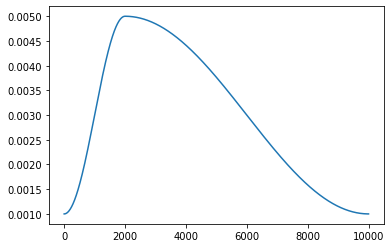

In [21]:
N = 10000
lr = get_cosine_triangular_lr(0.005, N)
plt.plot(list(range(N)), lr)
plt.show()

In [22]:
def train_epocs(model, train_dl, valid_dl, optimizer, epochs=10, num_hidden=50, max_lr=0.005):
    iterations = epochs*len(train_dl)
    pbar = tqdm(total=iterations)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    best_acc = 0
    ind = 0
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x1, x2, l, y in train_dl:
            update_optimizer(optimizer, lrs[ind])
            x1 = x1.cuda()
            x2 = x2.cuda()
            l = l.cuda()
            y = y.cuda()
            y_pred = model(x1, x2, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
            pbar.update()
            ind +=1
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("epoch % d train loss %.3f val loss %.3f and val accuracy %.3f" % (
            i, sum_loss/total, val_loss, val_acc))
        if val_acc > best_acc:
            path = "{0}/models/model_att_acc_{1}_{2:.0f}.pth".format(PATH, num_hidden, 100*val_acc) 
            save_model(model, path)
            best_acc = val_acc
            print(path)

In [23]:
def val_metrics(model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x1, x2, l, y in valid_dl:
        x1 = x1.cuda()
        x2 = x2.cuda()
        l = l.cuda()
        y = y.cuda()
        y_hat = model(x1, x2, l)
        loss = F.cross_entropy(y_hat, y)
        preds = torch.max(y_hat, dim=1)[1]
        correct += (preds==y).float().sum().item()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total, correct/total

In [24]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

## Training 
hidden_dim=128

In [25]:
batch_size=1000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [33]:
model = AttentiveReader(hidden_dim=128).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
train_epocs(model, train_dl, valid_dl, optimizer, epochs=20, num_hidden=128)

epoch  0 train loss 3.527 val loss 2.255 and val accuracy 0.370
/data2/yinterian/reading_comprehension/models/model_att_acc_128_37.pth
epoch  1 train loss 1.989 val loss 1.674 and val accuracy 0.549
/data2/yinterian/reading_comprehension/models/model_att_acc_128_55.pth
epoch  2 train loss 1.640 val loss 1.446 and val accuracy 0.615
/data2/yinterian/reading_comprehension/models/model_att_acc_128_61.pth
epoch  3 train loss 1.434 val loss 1.317 and val accuracy 0.645
/data2/yinterian/reading_comprehension/models/model_att_acc_128_65.pth
epoch  4 train loss 1.313 val loss 1.292 and val accuracy 0.656
/data2/yinterian/reading_comprehension/models/model_att_acc_128_66.pth
epoch  5 train loss 1.232 val loss 1.263 and val accuracy 0.664
/data2/yinterian/reading_comprehension/models/model_att_acc_128_66.pth
epoch  6 train loss 1.169 val loss 1.243 and val accuracy 0.669
/data2/yinterian/reading_comprehension/models/model_att_acc_128_67.pth
epoch  7 train loss 1.117 val loss 1.233 and val accura

In [26]:
model = AttentiveReader(hidden_dim=128).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
train_epocs(model, train_dl, valid_dl, optimizer, epochs=30, num_hidden=128)

epoch  0 train loss 3.524 val loss 2.156 and val accuracy 0.387
/data2/yinterian/reading_comprehension/models/model_att_acc_128_39.pth
epoch  1 train loss 2.044 val loss 1.755 and val accuracy 0.520
/data2/yinterian/reading_comprehension/models/model_att_acc_128_52.pth
epoch  2 train loss 1.716 val loss 1.543 and val accuracy 0.584
/data2/yinterian/reading_comprehension/models/model_att_acc_128_58.pth
epoch  3 train loss 1.524 val loss 1.393 and val accuracy 0.630
/data2/yinterian/reading_comprehension/models/model_att_acc_128_63.pth
epoch  4 train loss 1.387 val loss 1.296 and val accuracy 0.657
/data2/yinterian/reading_comprehension/models/model_att_acc_128_66.pth
epoch  5 train loss 1.293 val loss 1.266 and val accuracy 0.662
/data2/yinterian/reading_comprehension/models/model_att_acc_128_66.pth
epoch  6 train loss 1.219 val loss 1.262 and val accuracy 0.663
/data2/yinterian/reading_comprehension/models/model_att_acc_128_66.pth
epoch  7 train loss 1.161 val loss 1.249 and val accura

KeyboardInterrupt: 

In [ ]:
model = AttentiveReader(hidden_dim=128).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_epocs(model, train_dl, valid_dl, optimizer, epochs=30, num_hidden=128, max_lr=0.01)

In [ ]:
model = AttentiveReader(hidden_dim=128).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_epocs(model, train_dl, valid_dl, optimizer, epochs=30, num_hidden=128, max_lr=0.1)

## Training

In [ ]:
batch_size=1400
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
model = AttentiveReaderBN(hidden_dim=50).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
train_epocs(model, train_dl, valid_dl, optimizer, epochs=20, num_hidden=50)

In [ ]:
model = AttentiveReader(hidden_dim=50).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
train_epocs(model, train_dl, valid_dl, optimizer, epochs=30, num_hidden=50)

In [ ]:
model = AttentiveReaderBN(hidden_dim=50).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_epocs(model, train_dl, valid_dl, optimizer, epochs=30, num_hidden=50, lr=0.01)

## Model v2
* We need bidirectional LSTMs
* Initialize with pre-trained embeddings

## References
* https://arxiv.org/pdf/1606.02858v2.pdf
* https://github.com/danqi/rc-cnn-dailymail
* 